In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from catboost import CatBoostRegressor
from tqdm import tqdm
import gc
import datetime as dt

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
properties2016 = pd.read_csv('zillow/properties_2016.csv')
'''properties2017 = pd.read_csv('zillow/properties_2017.csv',error_bad_lines=False)'''

train2016 = pd.read_csv('zillow/train_2016_v2.csv', parse_dates=['transactiondate'])
train2017 = pd.read_csv('zillow/train_2017.csv', parse_dates=['transactiondate'])

def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = add_date_features(train2016)
'''train2017 = add_date_features(train2017)'''

sample_submission = pd.read_csv('zillow/sample_submission.csv')

train2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
'''train2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')'''


train_df = pd.concat([train2016, train2017], axis = 0)
test_df = pd.merge(sample_submission[['ParcelId']], properties2016.rename(columns = {'parcelid': 'ParcelId'}), how = 'left', on = 'ParcelId')

del properties2016, train2016
gc.collect();


/home/kai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].ix[train_df['logerror']<llimit] = llimit

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [4]:
train_df = train_df[[c for c in train_df if train_df[c].isnull().sum() < train_df.shape[0]/2]]

mean_values = train_df.median(axis=0)
train_df = train_df.fillna(mean_values, inplace=True)

In [5]:
from sklearn.cross_validation import train_test_split

y = train_df['logerror']

X_train, X_cv, y_train, y_cv = train_test_split(train_df.drop('logerror', axis=1), y, test_size=0.2, random_state=7)

X_train.shape, X_cv.shape, y_train.shape, y_cv.shape

/home/kai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((134310, 28), (33578, 28), (134310,), (33578,))

In [6]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

        
train_y = y_train
train_X = X_train.drop(["parcelid"], axis=1)

droplist = []
for fe in train_X:
    if train_X[fe].dtype == 'object':
        droplist.append(fe)

train_X = train_X.drop(droplist, axis=1)

xgb_params = {
    'nthread' : 8,
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

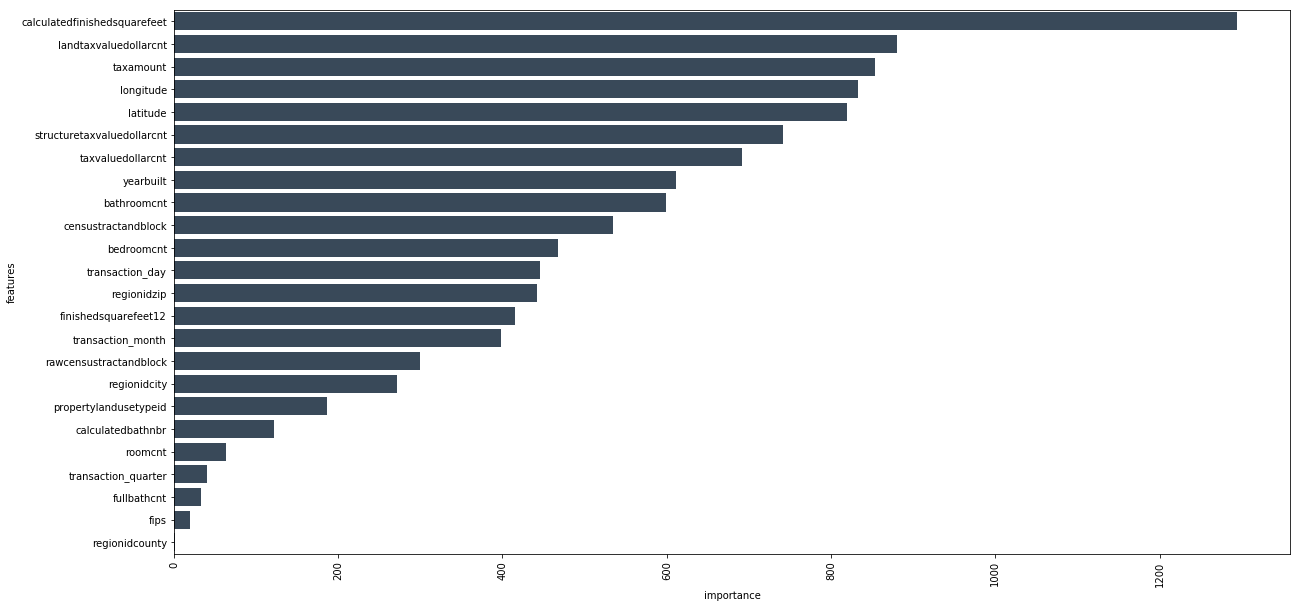

In [7]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [8]:
features = pd.DataFrame(features['features'].head(int(.9*features['features'].__len__())))
features.reset_index()


,index,features
0,4,calculatedfinishedsquarefeet
1,9,landtaxvaluedollarcnt
2,13,taxamount
3,2,longitude
4,16,latitude
5,14,structuretaxvaluedollarcnt
6,7,taxvaluedollarcnt
7,1,yearbuilt
8,8,bathroomcnt
9,15,censustractandblock


In [9]:
test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df = add_date_features(test_df)

features_test = np.append(features['features'].values,'ParcelId')

X_train = X_train.rename(columns = {'parcelid': 'ParcelId'})
X_cv = X_cv.rename(columns = {'parcelid': 'ParcelId'})

X_train = X_train[features_test]
X_cv = X_cv[features_test]

X_test = test_df[features_test]

mean_values = X_test.median(axis=0)
X_test = X_test.fillna(mean_values, inplace=True)

X_test.head()

,calculatedfinishedsquarefeet,landtaxvaluedollarcnt,taxamount,longitude,latitude,structuretaxvaluedollarcnt,taxvaluedollarcnt,yearbuilt,bathroomcnt,censustractandblock,bedroomcnt,transaction_day,regionidzip,finishedsquarefeet12,transaction_month,rawcensustractandblock,regionidcity,propertylandusetypeid,calculatedbathnbr,roomcnt,transaction_quarter,ParcelId
0,1572.0,9.0,3991.78,-118654084.0,34144442.0,122590.0,9.0,1963.0,0.0,6.037572e+13,0.0,1,96337.0,1539.0,12,6.037800e+07,37688.0,269.0,2.0,0.0,4,10754147
1,1572.0,27516.0,3991.78,-118625364.0,34140430.0,122590.0,27516.0,1963.0,0.0,6.037572e+13,0.0,1,96337.0,1539.0,12,6.037800e+07,37688.0,261.0,2.0,0.0,4,10759547
2,73026.0,762631.0,20800.37,-118394633.0,33989359.0,650756.0,1413387.0,1963.0,0.0,6.037572e+13,0.0,1,96095.0,1539.0,12,6.037703e+07,51617.0,47.0,2.0,0.0,4,10843547
3,5068.0,585488.0,14557.57,-118437206.0,34148863.0,571346.0,1156834.0,1948.0,0.0,6.037572e+13,0.0,1,96424.0,1539.0,12,6.037141e+07,12447.0,47.0,2.0,0.0,4,10859147
4,1776.0,239695.0,5725.17,-118385816.0,34194168.0,193796.0,433491.0,1947.0,0.0,6.037572e+13,0.0,1,96450.0,1539.0,12,6.037123e+07,12447.0,31.0,2.0,0.0,4,10879947


In [10]:
# Now let us look at the correlation coefficient of each of these variables #
'''x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
corr_df'''

"x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']\n\nlabels = []\nvalues = []\nfor col in x_cols:\n    labels.append(col)\n    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])\ncorr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})\ncorr_df = corr_df.sort_values(by='corr_values')\ncorr_df"

In [11]:
'''corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.01)]'''

"corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.01)]"

In [12]:
'''corr_df_ = pd.DataFrame()
for name in corr_df_sel['col_labels']:
    corr_df_[name] = train_df[name]

corr_df_.head()'''

"corr_df_ = pd.DataFrame()\nfor name in corr_df_sel['col_labels']:\n    corr_df_[name] = train_df[name]\n\ncorr_df_.head()"

In [13]:
'''from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

vifDict = calculate_vif_(corr_df_)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

validVariables, variablesWithMC'''

'from statsmodels.stats.outliers_influence import variance_inflation_factor  \nimport warnings\nwarnings.filterwarnings("ignore")\n\ndef calculate_vif_(X):\n    variables = list(X.columns)\n    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}\n    return vif\n\nvifDict = calculate_vif_(corr_df_)\n\nvifDf = pd.DataFrame()\nvifDf[\'variables\'] = vifDict.keys()\nvifDf[\'vifScore\'] = vifDict.values()\nvifDf.sort_values(by=[\'vifScore\'],ascending=False,inplace=True)\nvalidVariables = vifDf[vifDf["vifScore"]<=5]\nvariablesWithMC  = vifDf[vifDf["vifScore"]>5]\n\nvalidVariables, variablesWithMC'

In [14]:
'''valid_df = pd.DataFrame()

for name in validVariables['variables']:
    valid_df[name] = train_df[name]

valid_df.head()'''

"valid_df = pd.DataFrame()\n\nfor name in validVariables['variables']:\n    valid_df[name] = train_df[name]\n\nvalid_df.head()"

In [15]:
'''fe1 = []
for f in valid_df:
    fe1.append(f)
    
fe1.append('parcelid')
fe1.append('transaction_year')
fe1.append('transaction_month')
fe1.append('transaction_day')
fe1.append('transaction_quarter')

fe1'''

"fe1 = []\nfor f in valid_df:\n    fe1.append(f)\n    \nfe1.append('parcelid')\nfe1.append('transaction_year')\nfe1.append('transaction_month')\nfe1.append('transaction_day')\nfe1.append('transaction_quarter')\n\nfe1"

In [10]:
test_date = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']

test_columns = ['201610','201611','201612','201710','201711','201712']

from datetime import datetime

test_dates = []
for d in test_date:
    test_dates.append(datetime.strptime(d, '%Y-%m-%d'))
test_dates

[datetime.datetime(2016, 10, 1, 0, 0),
 datetime.datetime(2016, 11, 1, 0, 0),
 datetime.datetime(2016, 12, 1, 0, 0),
 datetime.datetime(2017, 10, 1, 0, 0),
 datetime.datetime(2017, 11, 1, 0, 0),
 datetime.datetime(2017, 12, 1, 0, 0)]

In [11]:
X_train.shape, y_train.shape

((195797, 9), (195797,))

In [21]:
X_train_2 = X_train.drop('ParcelId', axis=1)

xgb_params2 = {
    'nthread' : 8,
    'eta': 0.05,
    'max_depth': 10,
    'subsample': .8,
    'colsample_bytree': .8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

dtrain = xgb.DMatrix(X_train_2, y_train, feature_names=X_train_2.columns.values)
model = xgb.train(dict(xgb_params2, silent=0), dtrain, num_boost_round=100)

In [22]:
X_cv2 = X_cv.drop('ParcelId', axis=1)
dtrain2 = xgb.DMatrix(X_cv2, feature_names=X_cv2.columns.values)
pred_val = model.predict(dtrain2)

In [14]:
y_cv.shape, pred_val.shape

((48950,), (48950,))

In [13]:
from sklearn.metrics import mean_squared_error as mse

In [23]:
mse(y_cv, pred_val)

0.010347516439238166

In [23]:
y_cv.describe()

count    18055.000000
mean         0.010491
std          0.099794
min         -0.342500
25%         -0.025300
50%          0.006000
75%          0.038300
max          0.463882
Name: logerror, dtype: float64

In [15]:
print(list(y_cv)[:10])
print(pred_val[:10])

[0.065799999999999997, -0.058700000000000002, 0.0129, 0.40550000000000003, -0.00019327424892400002, 0.020746167104499998, -0.001, 0.038300000000000001, -0.029399999999999999, -0.037120050850199995]
[ 0.02559853  0.02211609  0.01090488  0.01535717  0.01655546  0.01655546
  0.0240185   0.00390241  0.02194533  0.01655546]


In [25]:
X_cv.shape, y_cv.shape

((18055, 26), (18055,))

In [26]:
X_train.shape, y_train.shape

((72220, 26), (72220,))

In [24]:
X_test = X_test.drop('ParcelId', axis=1)

for i in range(len(test_dates)):
    X_test['transactiondate'] = test_dates[i]
    X_test = add_date_features(X_test)
    X_test = X_test[features['features'].values]    
    dtrain_temp = xgb.DMatrix(X_test, feature_names=X_test.columns.values)
    pred = model.predict(dtrain_temp)
    sample_submission[test_columns[i]] = [float(format(x, '.4f')) for x in pred]

In [25]:
sample_submission.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)